In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns
import cell2location

2024-11-21 18:03:05.001418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 18:03:05.009710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 18:03:05.012141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 18:03:05.453953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Load datas

In [27]:
# set paths
sp_data_folder = '/home/jsw/BI/Database/Ravi_Cancer_Cell_2022/10XVisium_2/'
results_folder = './results/'

regression_model_output = 'RegressionModelOutput'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

def read_and_qc(sample_name, path = sp_data_folder, batch = None):
    r'''Reads the data for one 10X spatial experiment into the anndata object
    It also calculates QC metrics
    
    :param sample_name: Name of the sample
    :param path: path to data
    '''
    adata = sc.read_visium(path + str(sample_name) + '/outs/',
                           count_file = 'filtered_feature_bc_matrix.h5', load_images = True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.obs['Batch'] = batch
    adata.var.rename(columns = {'gene_ids': 'ENSEMBL'}, inplace = True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns = 'ENSEMBL', inplace = True)
    
    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['MT_frac'] = adata[:, adata.var['MT'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs['sapmle'] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs['sample'] + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata


def select_slide(adata, s, s_col = 'sample'):
    r'''Selets the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    '''
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]
    
    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [3]:
# read csv and store the first column as list
import pandas as pd
sample_data = pd.read_csv('../spatial_data.csv')
sample_data['combined_id'] = sample_data['ID'] + '_' + sample_data['Tissue_Type'] + '_ST'

In [7]:
sample_data

,ID,Tissue_Type,Batch,Region,Age,Tumor,Histology,Sex,MALDI,IMC,combined_id
0,#UKF275,T,6,frontal,80,IDH-WT,GBM,f,1.0,1.0,#UKF275_T_ST
1,#UKF270,T,6,frontal,41,IDH-MUT,AA,m,NaN,NaN,#UKF270_T_ST
2,#UKF269,T,6,occipital,51,IDH-WT,GBM,m,NaN,NaN,#UKF269_T_ST
3,#UKF268,T,6,frontal,49,IDH-MUT,ODG,f,NaN,NaN,#UKF268_T_ST
4,#UKF262,T,5,temporal,59,IDH-WT,GBM,m,1.0,1.0,#UKF262_T_ST
5,#UKF260,T,5,temporal,81,IDH-WT,GBM,m,1.0,1.0,#UKF260_T_ST
6,#UKF255,T,5,temporal,81,IDH-WT,GBM,f,NaN,NaN,#UKF255_T_ST
7,#UKF248,T,1,frontal,44,IDH-WT,GBM,m,NaN,NaN,#UKF248_T_ST
8,#UKF243,T,1,frontal,55,IDH-WT,GBM,f,NaN,NaN,#UKF243_T_ST
9,#UKF304,T,9,temporal,81,IDH-WT,GBM,m,NaN,NaN,#UKF304_T_ST


In [31]:
slides = []
for batch, combined_id in zip(sample_data['Batch'], sample_data['combined_id']):
    slides.append(read_and_qc(combined_id, batch = batch))
    
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    # batch_key='batch',
    uns_merge='unique',
    # batch_categories=sample_data['combined_id'],
    index_unique=None
)

# replace the sample names with the new names
spatial_to_sample = pd.read_csv('../spatial_to_sample.csv')
for index, row in spatial_to_sample.iterrows():
    old_key = row['old']
    new_key = row['new']
    if old_key in adata.uns['spatial']:
        adata.uns['spatial'][new_key] = adata.uns['spatial'].pop(old_key)
    

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_m

/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['sp

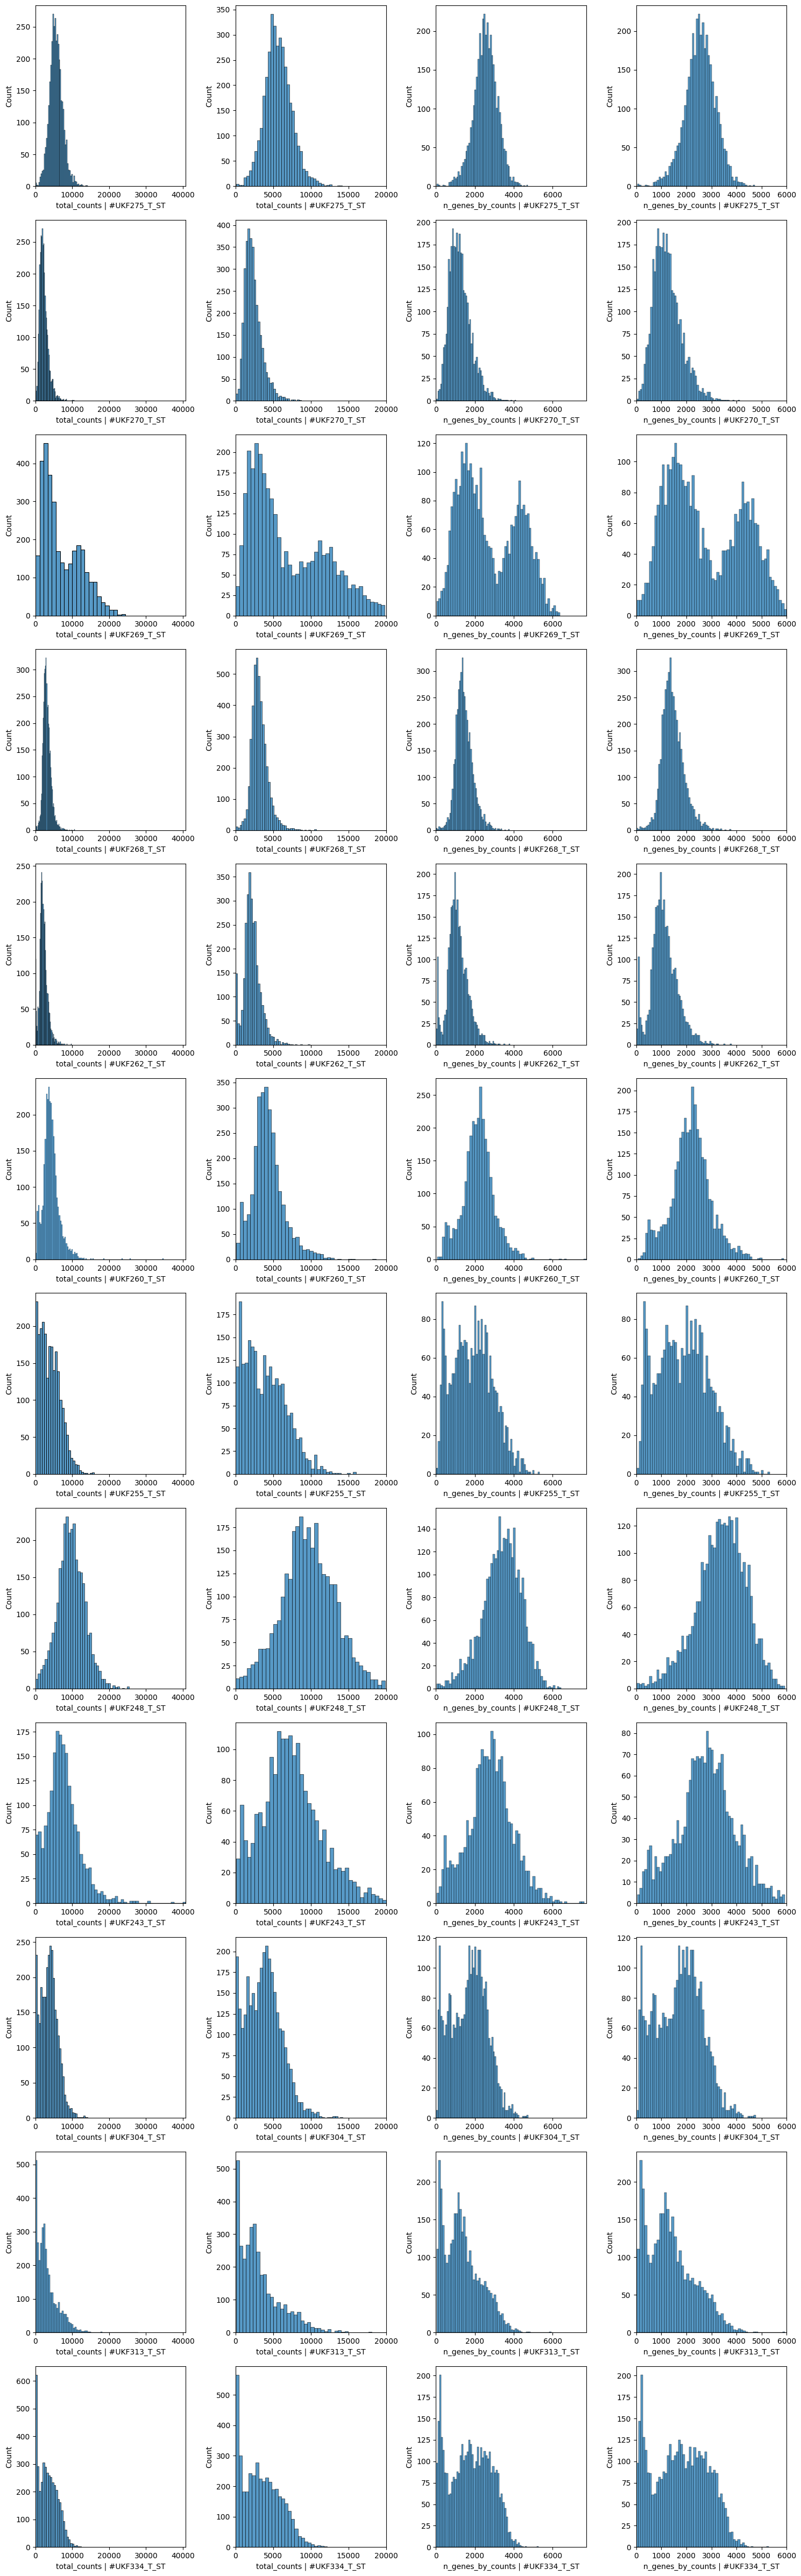

In [33]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    
    sns.histplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

---
# Visualize

In [34]:
# Select slide
slide = select_slide(adata, '#UKF243_T_ST')

/tmp/ipykernel_22527/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}


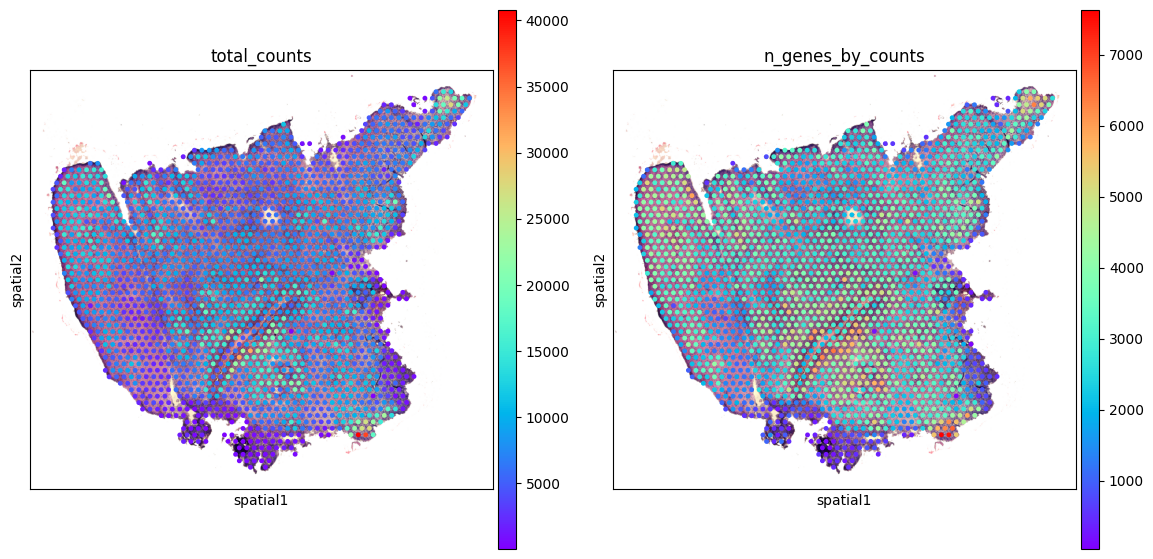

In [35]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        img_key = "hires",
        cmap='rainbow',
        library_id=list(slide.uns['spatial'].keys())[0],
        color=['total_counts', 'n_genes_by_counts'],
        size=1,
        gene_symbols='SYMBOL',
        show=False,
        return_fig=True
    )

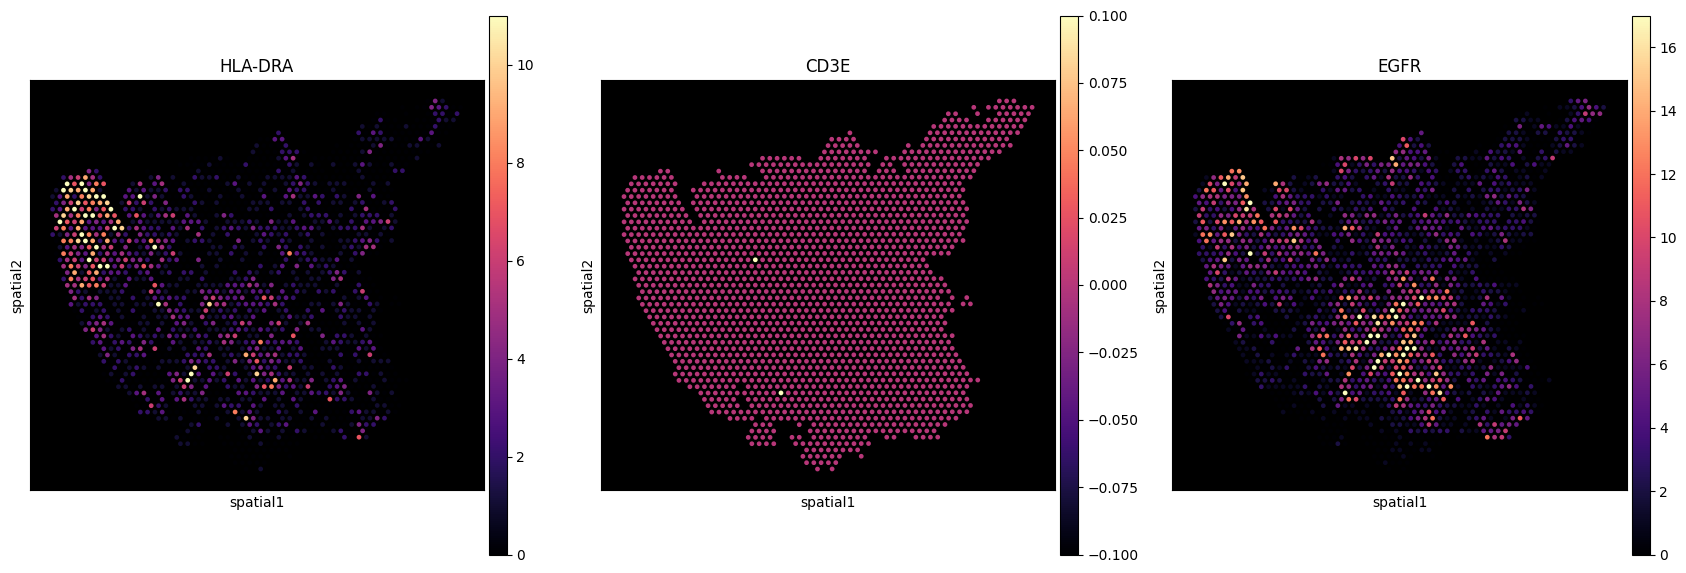

In [36]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        color=["HLA-DRA", "CD3E", "EGFR"],
        img_key=None,
        size=1,
        vmin=0,
        cmap='magma',
        vmax='p99.0',
        gene_symbols='SYMBOL'
    )

---
# cell2location

In [37]:
inf_aver = pd.read_csv('../data/inf_aver.csv', index_col = 0)

In [38]:
adata.obs

,in_tissue,array_row,array_col,sample,Batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,MT_frac,sapmle,batch
spot_id,,,,,,,,,,,,,,,,
#UKF275_T_ST_AAACAAGTATCTCCCA-1,1,50,102,#UKF275_T_ST,6,2173,7.684324,4572.0,8.427925,27.974628,36.329834,45.778653,60.848644,0.102143,#UKF275_T_ST,0
#UKF275_T_ST_AAACACCAATAACTGC-1,1,59,19,#UKF275_T_ST,6,2856,7.957527,6303.0,8.748940,23.449151,31.302554,40.948755,55.941615,0.097414,#UKF275_T_ST,0
#UKF275_T_ST_AAACAGAGCGACTCCT-1,1,14,94,#UKF275_T_ST,6,2840,7.951911,5999.0,8.699514,21.736956,29.288215,38.773129,54.175696,0.049008,#UKF275_T_ST,0
#UKF275_T_ST_AAACAGCTTTCAGAAG-1,1,43,9,#UKF275_T_ST,6,3710,8.219057,8736.0,9.075322,21.668956,29.384158,38.518773,52.209249,0.031364,#UKF275_T_ST,0
#UKF275_T_ST_AAACAGGGTCTATATT-1,1,47,13,#UKF275_T_ST,6,3763,8.233238,8512.0,9.049350,20.935150,28.042763,36.783365,50.599154,0.045113,#UKF275_T_ST,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#UKF334_T_ST_TTGTTGTGTGTCAAGA-1,1,31,77,#UKF334_T_ST,10,2101,7.650645,3605.0,8.190354,17.836338,25.325936,35.090153,53.342580,0.028849,#UKF334_T_ST,11
#UKF334_T_ST_TTGTTTCACATCCAGG-1,1,58,42,#UKF334_T_ST,10,2483,7.817625,4894.0,8.495970,19.084593,27.523498,37.903555,54.147936,0.035962,#UKF334_T_ST,11
#UKF334_T_ST_TTGTTTCATTAGTCTA-1,1,60,30,#UKF334_T_ST,10,1714,7.447168,2844.0,7.953319,19.303797,27.742616,38.045007,57.313643,0.042194,#UKF334_T_ST,11


In [39]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata.var_names, inf_aver.index)
adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(
    adata = adata,
    batch_key = 'Batch'
)

In [40]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata,
    cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Batch',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 38773 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 22425 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Batch'] │     1      │          0          │
│                    │     5      │          1          │
│                    │     6      │          2          │
│                    │     9      │          3          │
│                    │     10     │          4          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
import torch

In [ ]:
torch.cuda.empty_cache()

In [42]:
mod.train(
    max_epochs = 2000,
    batch_size = 4096,
    train_size = 1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


---

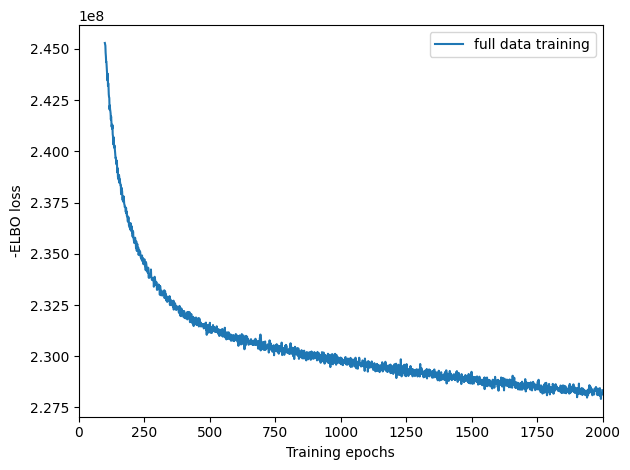

In [43]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['full data training'])

In [44]:
# Export the estimated cell abundance (summary of the posterior distribution)
adata = mod.export_posterior(
    adata,
    sample_kwargs = {
        'num_samples': 1000,
        'batch_size': 2000
    }
)

Sampling local variables, batch:   0%|          | 0/20 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

In [45]:
# save model
mod.save('run_model', overwrite = True)

In [46]:
# save anndata object with results
adata.write('run_model/sp.h5ad')

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns
import cell2location

In [ ]:
import torch
torch.no_grad()

In [ ]:
# load adata
adata = sc.read_h5ad('run_model/sp.h5ad')
# mod = cell2location.models.Cell2location.load('run_model', adata)

In [ ]:
mod.plot_QC()

In [47]:
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

In [48]:
adata.obs.rename(columns = {"CD4": "CD4_T"}, inplace = True)
adata.var.set_index('SYMBOL', inplace = True)

In [49]:
# Normalization
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

/home/jsw/jswenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [ ]:
%matplotlib tk
# %matplotlib inline

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


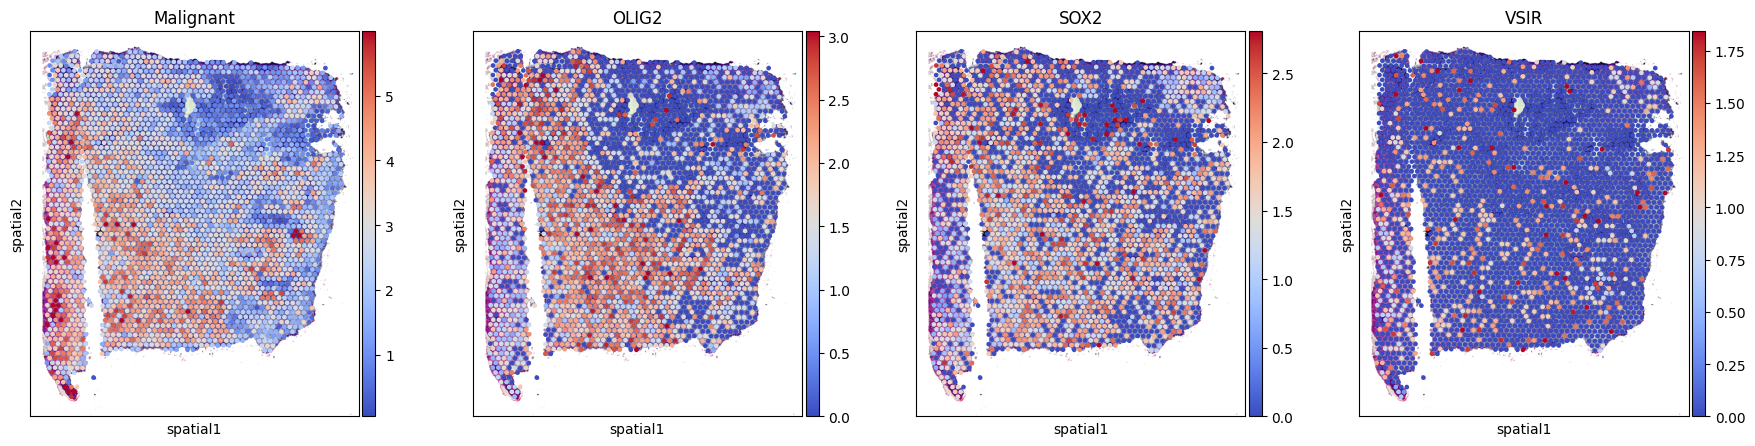

In [160]:
selected_slide = '#UKF260_T_ST'
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata, selected_slide)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(
        slide,
        cmap='coolwarm',
        # show first 8 cell types
       #  color=['Malignant', 'EGFR', 'MAP2', 'TUBB3', 'SNAP25', 'GFAP', 'OLIG2', 'MBP', 'TMEM119', 'P2RY12', 'AIF1', 'CD14', 'MG/Mp', 'ILC/gdT', 'CD4_T', 'Oligodendrocytes',
       #         'Treg', 'CD8', 'DC', 'Neutrophils'],
       color = ['Malignant', 'OLIG2', 'SOX2', 'VSIR'],
        # color = ['MG/Mp', 'TMEM119', 'P2RY12', 'CD14', 'H1LA-DRA', 'CD4_T', 'Treg', 'CD8', 'Malignant', 'EGFR'],
       #  color = ['Malignant', 'MG/Mp', 'NSUN5', 'PILRB'],
        ncols=5,
        size=1.3,
        img_key='hires',
        # limit color scale at 99.2% quantile of cell abundance
       #  vmin = 3,
        vmax = 'p99.2',
       #  vmax = 6
)

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['Malignant', 'MG/Mp', 'CD4_T']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata, selected_slide)

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='dark_background',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right',
        img_alpha = 0.3,
        reorder_cmap = range(1, 7)
    )
plt.show()
